In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dữ liệu

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/train.csv')
valid_translated = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/valid_translated.csv')
valid = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/test.csv')

Hàm hỗ trợ tính toán recall, precision và f1

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Hàm vẽ đồ thị

In [ ]:
def visu(history, title='F1 and Accuracy'):
    fig = plt.figure()
    axs = fig.add_axes([0, 0, 1, 1])
    axs.set_title(title)
    axs.plot(history.history['f1_m'], label='F1 train')
    axs.plot(history.history['val_f1_m'], label='F1 valid')
    axs.plot(history.history['accuracy'], label='Accuracy train')
    axs.plot(history.history['val_accuracy'], label='Accuracy valid')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Percent')
    axs.set_ylim(0, 1)
    axs.legend()
    fig.show()

In [ ]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()
    plt.show()

# Model 1
Không normalization, không sử dụng pre-train embedding

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Xây dựng model

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, input_length=max_len))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          11750000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

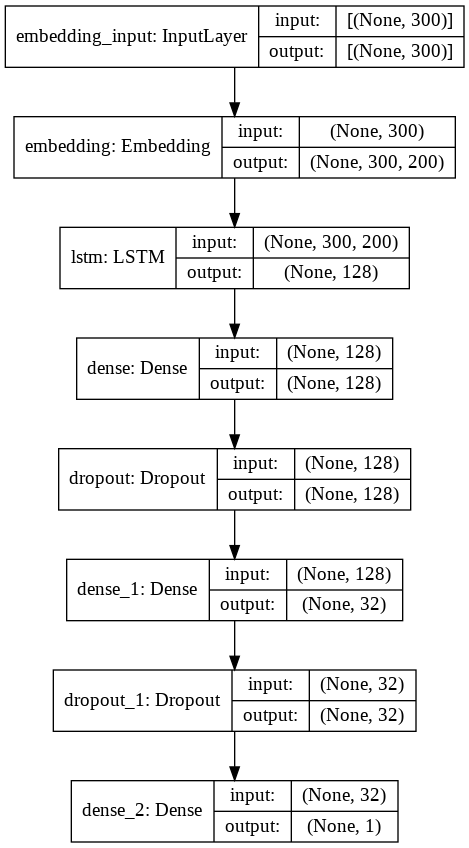

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 215s 3s/step - loss: 0.3296 - accuracy: 0.9075 - precision_m: 0.1449 - recall_m: 0.0391 - f1_m: 0.0542 - val_loss: 0.4775 - val_accuracy: 0.8674 - val_precision_m: 0.8757 - val_recall_m: 0.1646 - val_f1_m: 0.2699

Epoch 00001: val_f1_m improved from -inf to 0.26993, saving model to modelLSTM_1.hdf5
Epoch 2/25
79/79 [==============================] - 212s 3s/step - loss: 0.1452 - accuracy: 0.9543 - precision_m: 0.9125 - recall_m: 0.5755 - f1_m: 0.6819 - val_loss: 0.5794 - val_accuracy: 0.8629 - val_precision_m: 0.5865 - val_recall_m: 0.3588 - val_f1_m: 0.4392

Epoch 00002: val_f1_m improved from 0.26993 to 0.43920, saving model to modelLSTM_1.hdf5
Epoch 3/25
79/79 [==============================] - 210s 3s/step - loss: 0.1356 - accuracy: 0.9695 - precision_m: 0.9061 - recall_m: 0.7766 - f1_m: 0.8279 - val_loss: 1.1845 - val_accuracy: 0.8780 - val_precision_m: 0.8106 - val_recall_m: 0.2687 - val_f1_m: 0.3970

Epoch 00003: val_f1_m did n

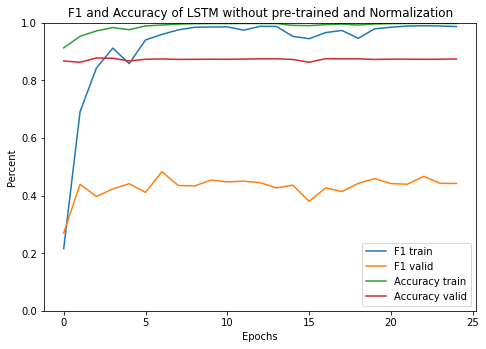

In [ ]:
checkpoint = ModelCheckpoint('modelLSTM_1.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of LSTM without pre-trained and Normalization')

model.load_weights('modelLSTM_1.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

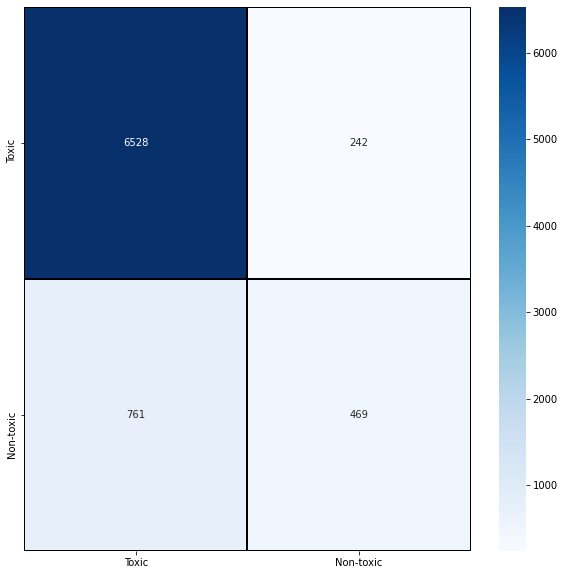

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

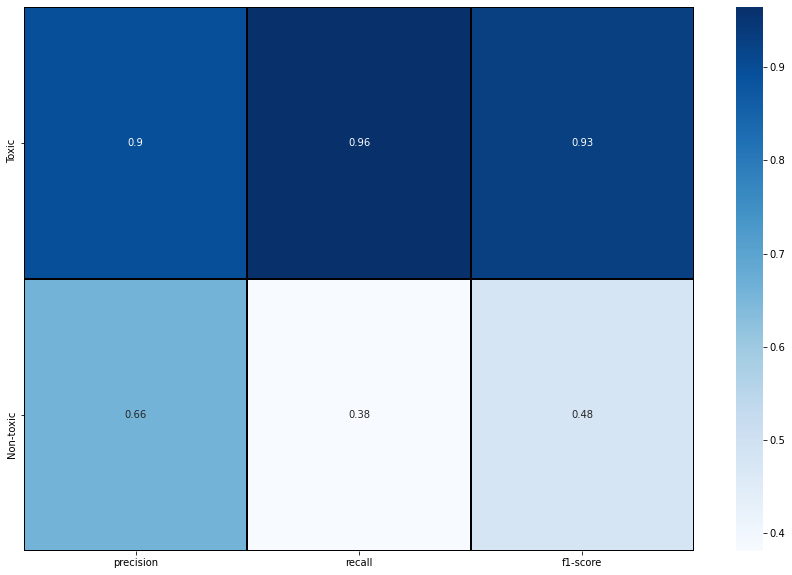

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 2

Sử dụng pre-trained model (GloVe)

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Add embedded model (GloVe)

In [ ]:
#Add GloVe
GloVe = {}
for line in open('/content/drive/MyDrive/Diplom/GloVe/glove.twitter.27B.200d.txt', encoding="utf8"):
    split = line.split()
    word = split[0]
    vector = [float(x) for x in split[1:]]
    GloVe[word] = np.array(vector)


In [ ]:
#Transform to embedding matrix
embedding_matrix = np.zeros((len(word_index)+1, 200))
for item in word_index.items():
    word = item[0]
    i = item[1]
    if GloVe.get(word) is not None:
        embedding_matrix[i] = GloVe[word]

Xây dựng model (sử dụng non-trainable embedding matrix)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, 
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length=max_len))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          11750000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,943,281
Trainable params: 193,281
Non-trainable params: 11,750,000
______________________________________

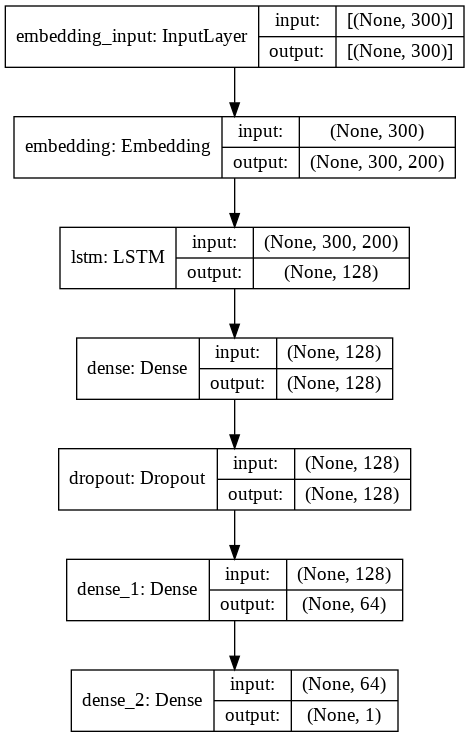

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 169s 2s/step - loss: 0.4312 - accuracy: 0.9067 - precision_m: 0.4426 - recall_m: 0.1065 - f1_m: 0.1439 - val_loss: 0.4280 - val_accuracy: 0.8564 - val_precision_m: 0.7478 - val_recall_m: 0.0898 - val_f1_m: 0.1579

Epoch 00001: val_f1_m improved from -inf to 0.15795, saving model to modelLSTM_2.hdf5
Epoch 2/25
79/79 [==============================] - 165s 2s/step - loss: 0.2984 - accuracy: 0.9237 - precision_m: 0.8204 - recall_m: 0.3338 - f1_m: 0.4499 - val_loss: 0.7888 - val_accuracy: 0.8714 - val_precision_m: 0.8431 - val_recall_m: 0.2029 - val_f1_m: 0.3219

Epoch 00002: val_f1_m improved from 0.15795 to 0.32186, saving model to modelLSTM_2.hdf5
Epoch 3/25
79/79 [==============================] - 166s 2s/step - loss: 0.2421 - accuracy: 0.9346 - precision_m: 0.7743 - recall_m: 0.4610 - f1_m: 0.5621 - val_loss: 0.9062 - val_accuracy: 0.8465 - val_precision_m: 0.0937 - val_recall_m: 0.0024 - val_f1_m: 0.0046

Epoch 00003: val_f1_m did n

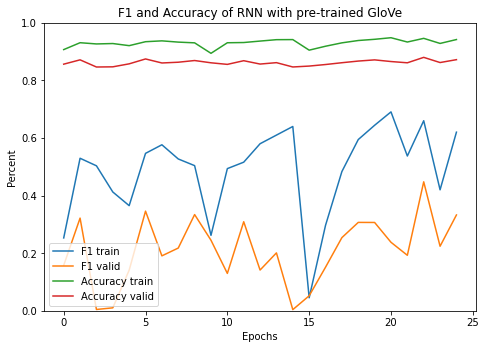

In [ ]:
checkpoint = ModelCheckpoint('modelLSTM_2.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of RNN with pre-trained GloVe')

model.load_weights('modelLSTM_2.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

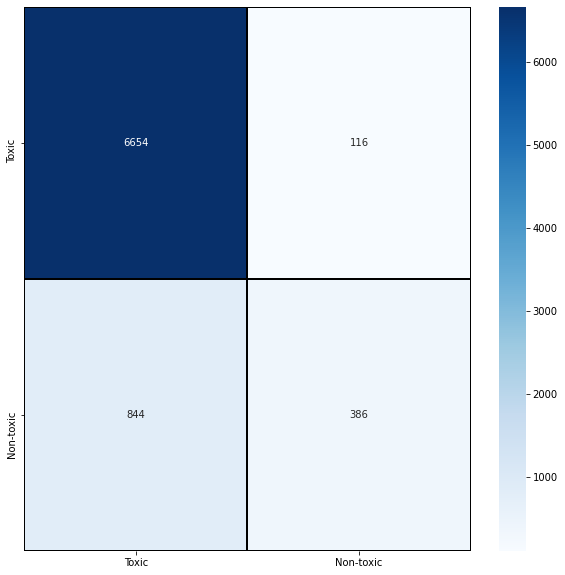

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

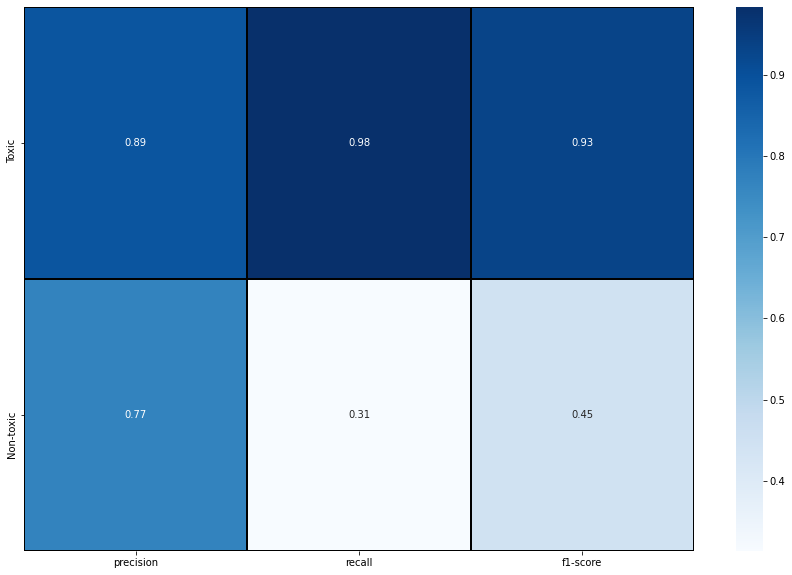

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 3
Sử dụng data cleaning

In [ ]:
def to_lower_case(text):
    return text.lower()

def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_HTMLs(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_annotations(text):
    annotation = re.compile(r'\[[^]]*\]')
    return annotation.sub(r'', text)

def remove_punctuations(text):
    punctuation = re.compile(r'[^a-z]+')
    return punctuation.sub(r' ', text)

stop_words_list = set(stopwords.words('english'))

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    return ' '.join(text)

lemmatizer = WordNetLemmatizer()

def pos_recognition(tag):
    if (tag[0] == 'J'):
        return 'a'
    if (tag[0] == 'N'):
        return 'n'
    if (tag[0] == 'R'):
        return 'r'
    if (tag[0] == 'V'):
        return 'v'
    return ''

def lemmatization(text):
    text = nltk.pos_tag(text.split())
    for i in range(len(text)):
        if (pos_recognition(text[i][1]) != ''):
            text[i] = lemmatizer.lemmatize(text[i][0], pos = pos_recognition(text[i][1]))
        else:
            text[i] = lemmatizer.lemmatize(text[i][0])
    return ' '.join(text)

def data_clean(x):
  x = to_lower_case(x)
  x = remove_URLs(x)
  x = remove_HTMLs(x)
  x = remove_annotations(x)
  x = remove_punctuations(x)
  x = remove_stopwords(x)
  x = lemmatization(x)
  x = x.replace('  ', ' ')
  return x

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Data cleaning

In [ ]:
x_train = [data_clean(x) for x in x_train]
x_valid = [data_clean(x) for x in x_valid]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Xây dựng model (Sử dụng data cleaning)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, input_length=max_len))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          9184400   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,377,681
Trainable params: 9,377,681
Non-trainable params: 0
______________________________________________

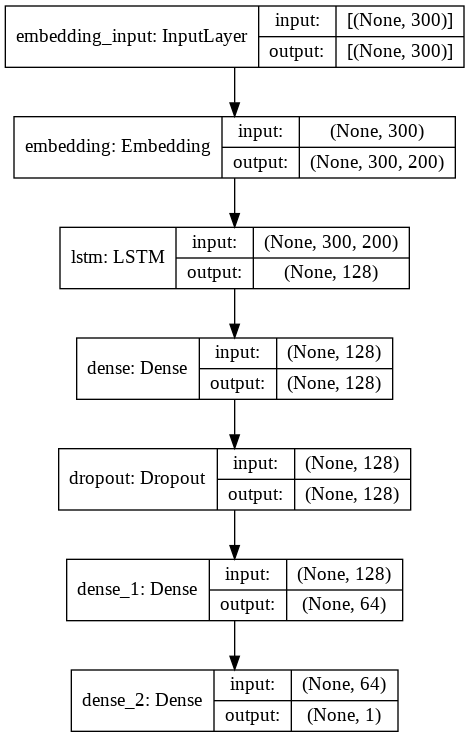

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
checkpoint = ModelCheckpoint('modelLSTM_3.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of LSTM with normalization')

model.load_weights('modelLSTM_3.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

Epoch 1/25
79/79 [==============================] - 215s 3s/step - loss: 0.3442 - accuracy: 0.9079 - precision_m: 0.1513 - recall_m: 0.0464 - f1_m: 0.0656 - val_loss: 0.3909 - val_accuracy: 0.8721 - val_precision_m: 0.7708 - val_recall_m: 0.2307 - val_f1_m: 0.3499

Epoch 00001: val_f1_m improved from -inf to 0.34994, saving model to modelLSTM_3.hdf5
Epoch 2/25
79/79 [==============================] - 211s 3s/step - loss: 0.1336 - accuracy: 0.9643 - precision_m: 0.9010 - recall_m: 0.7205 - f1_m: 0.7941 - val_loss: 0.3991 - val_accuracy: 0.8755 - val_precision_m: 0.7061 - val_recall_m: 0.3310 - val_f1_m: 0.4440

Epoch 00002: val_f1_m improved from 0.34994 to 0.44404, saving model to modelLSTM_3.hdf5
Epoch 3/25
79/79 [==============================] - 209s 3s/step - loss: 0.0841 - accuracy: 0.9800 - precision_m: 0.9580 - recall_m: 0.8301 - f1_m: 0.8842 - val_loss: 1.1530 - val_accuracy: 0.8767 - val_precision_m: 0.7074 - val_recall_m: 0.3447 - val_f1_m: 0.4574

Epoch 00003: val_f1_m impro

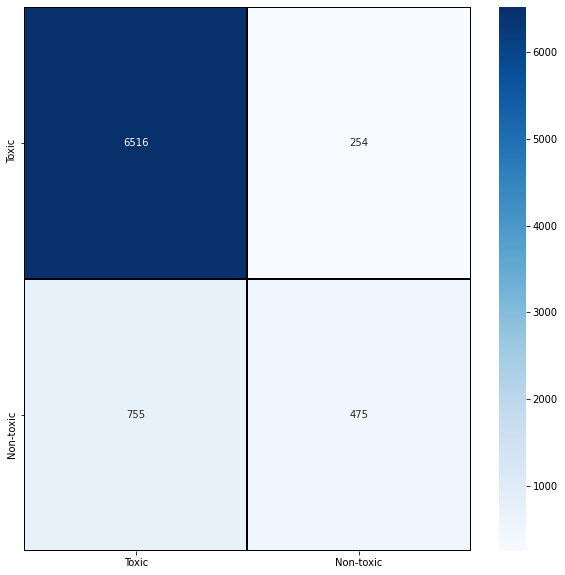

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

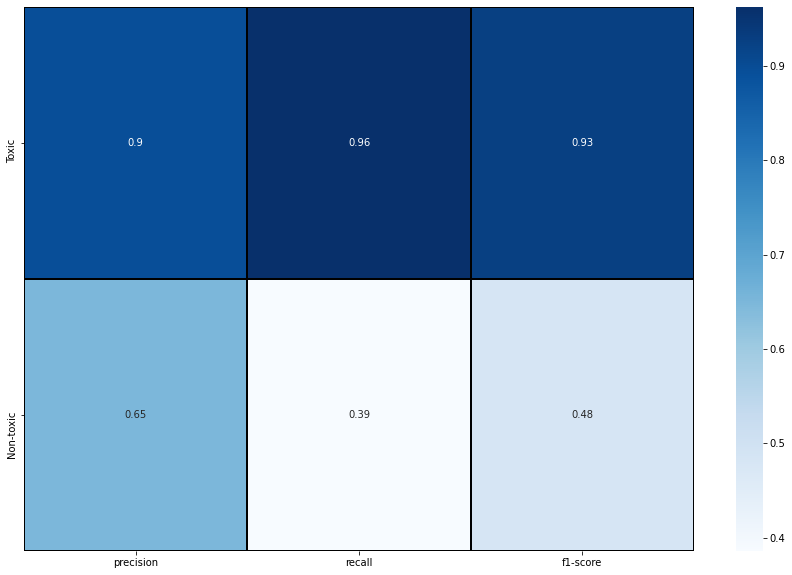

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 4
Sử dụng kết hợp pre-trained model và normilization

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Data cleaning

In [ ]:
x_train = [data_clean(x) for x in x_train]
x_valid = [data_clean(x) for x in x_valid]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Thêm embedded matrix

In [ ]:
#Transform to embedding matrix
embedding_matrix = np.zeros((len(word_index)+1, 200))
for item in word_index.items():
    word = item[0]
    i = item[1]
    if GloVe.get(word) is not None:
        embedding_matrix[i] = GloVe[word]

Xây dựng model (sử dụng embedding matrix và data cleaning)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, 
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          9184400   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 256)          336896    
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 128)          98432     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

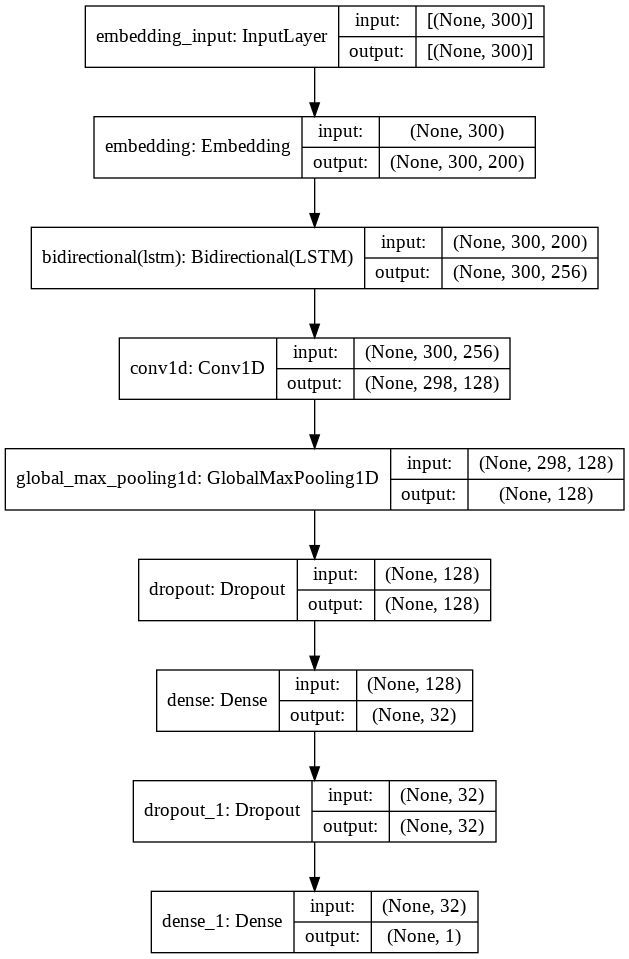

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 426s 5s/step - loss: 0.2956 - accuracy: 0.8909 - precision_m: 0.3071 - recall_m: 0.1863 - f1_m: 0.2043 - val_loss: 0.2999 - val_accuracy: 0.8829 - val_precision_m: 0.6804 - val_recall_m: 0.4624 - val_f1_m: 0.5457

Epoch 00001: val_f1_m improved from -inf to 0.54571, saving model to modelLSTM_4.hdf5
Epoch 2/25
79/79 [==============================] - 419s 5s/step - loss: 0.1293 - accuracy: 0.9517 - precision_m: 0.7880 - recall_m: 0.6936 - f1_m: 0.7261 - val_loss: 0.3639 - val_accuracy: 0.8795 - val_precision_m: 0.8269 - val_recall_m: 0.2873 - val_f1_m: 0.4197

Epoch 00002: val_f1_m did not improve from 0.54571
Epoch 3/25
79/79 [==============================] - 407s 5s/step - loss: 0.1129 - accuracy: 0.9591 - precision_m: 0.8657 - recall_m: 0.6887 - f1_m: 0.7600 - val_loss: 0.3528 - val_accuracy: 0.8859 - val_precision_m: 0.7585 - val_recall_m: 0.3854 - val_f1_m: 0.5056

Epoch 00003: val_f1_m did not improve from 0.54571
Epoch 4/25
79/

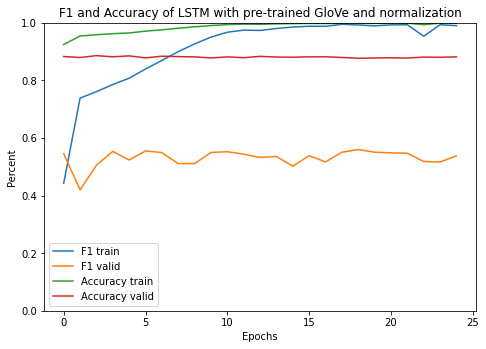

In [ ]:
checkpoint = ModelCheckpoint('modelLSTM_4.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of LSTM with pre-trained GloVe and normalization')

model.load_weights('modelLSTM_4.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

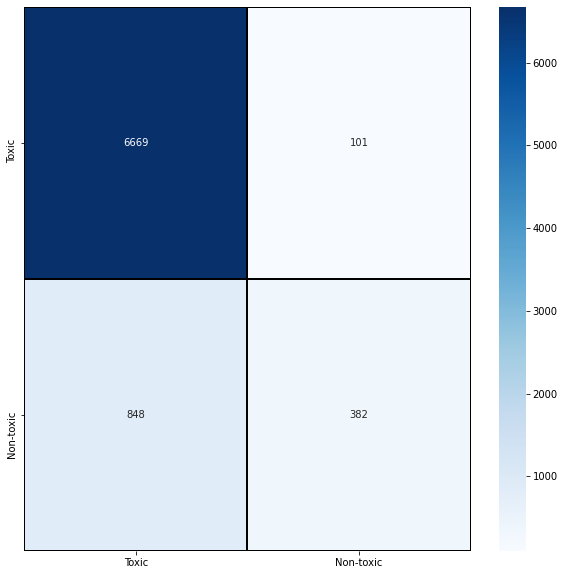

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

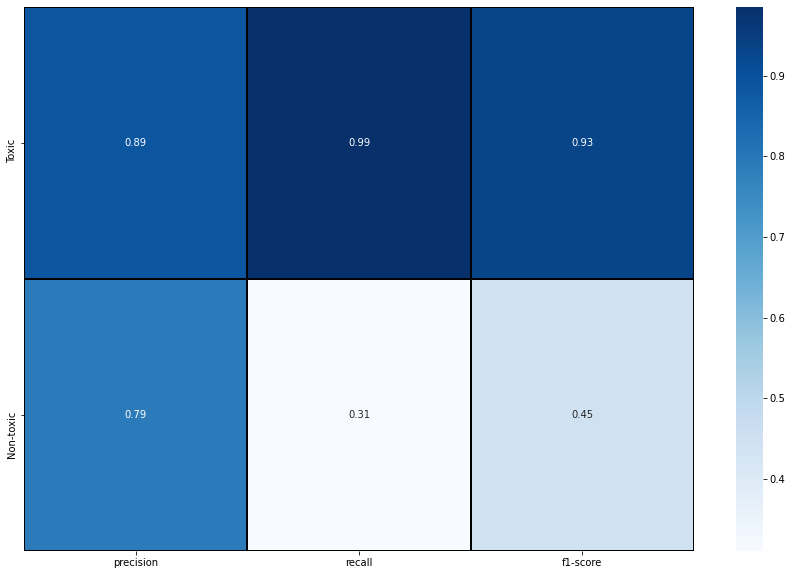

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()